In [412]:
import numpy as np
import time
import matplotlib.pyplot as plt
from pynq import allocate

In [413]:
from pynq import PL
PL.reset()
import xrfdc

In [414]:
from pynq import Overlay
ol = Overlay('./final_debug.bit')

In [415]:
# sanity check that we are at 150 MHz
from pynq import Clocks
Clocks.pl_clk0_mhz = 150
print(Clocks.pl_clk0_mhz)

150


In [416]:
rf = ol.usp_rf_data_converter_0
adc_tile = rf.adc_tiles[2]
adc_block = adc_tile.blocks[0]
adc_block.Dither = 0 #doesn't really matter for this lab, but let's turn off.
center_frequency = 1575.43
doppler = -800
adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
print(adc_block.MixerSettings)

{'Freq': 1575.4291999999987, 'PhaseOffset': 0.0, 'EventSource': 2, 'CoarseMixFreq': 0, 'MixerMode': 3, 'FineMixerScale': 0, 'MixerType': 2}


In [417]:
N = 4096
num_width = 32

In [418]:
mmio_interface = ol.mmio_interface
dma_output = ol.axi_dma_0
dma_prn_config = ol.axi_prn_config
dma_iq_config = ol.axi_iq_config
dma_ifft_config = ol.axi_ifft_config

In [419]:
dma_iq = ol.axi_iq
dma_prn = ol.axi_prn

In [420]:
# set up ffts
fft_config = allocate(1, dtype=np.uint8)
fft_config[0] = 0
ifft_config = allocate(1, dtype=np.uint8)
ifft_config[0] = 1
# note they are default inverse (1)
dma_prn_config.sendchannel.transfer(fft_config)
dma_prn_config.sendchannel.wait()
dma_iq_config.sendchannel.transfer(fft_config)
dma_iq_config.sendchannel.wait()
dma_ifft_config.sendchannel.transfer(ifft_config)
dma_ifft_config.sendchannel.wait()

In [421]:
# numerical helpers
def get_twos_from_decimal(decimal, num_bits):
    decimal = int(decimal)
    return decimal % (1<<num_bits)

def get_value_from_complex(real, imag, num_bits):
    return get_twos_from_decimal(real, num_bits)*(1<<num_bits)+get_twos_from_decimal(imag, num_bits)

def get_decimal_from_twos(twos, num_bits):
    twos = int(twos)
    if twos >= (1<<(num_bits-1)):
        return twos - (1<<num_bits)
    else:
        return twos
    
def get_components(complex_array, num_bits):
    return {
        'real': np.array([get_decimal_from_twos(x // (1<<num_bits), num_bits) for x in complex_array]),
        'imag': np.array([get_decimal_from_twos(x % (1<<num_bits), num_bits) for x in complex_array])
    }

In [422]:
mmio_interface.write(0x00, 18)

In [423]:
mmio_interface.write(0x08, 0)
time.sleep(0.002)
mmio_interface.write(0x04, 0) # PRN 1
mmio_interface.write(0x08, 1)

In [424]:
iq_complex = get_components(iq_data, 16)
prn_complex = get_components(prn_data, 16)
iq_numpy = np.array([x+y*1j for (x, y) in zip(iq_complex['real'], iq_complex['imag'])])
prn_numpy = np.array([x+y*1j for (x, y) in zip(prn_complex['real'], prn_complex['imag'])])

In [425]:
convolve = np.fft.ifft(np.fft.fft(iq_numpy) * np.fft.fft(prn_numpy).conj())

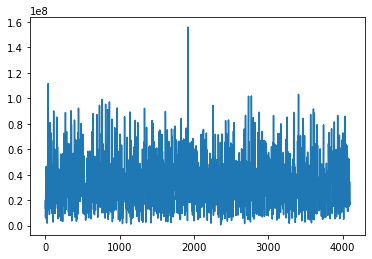

In [426]:
plt.plot(list(range(N)), abs(convolve))

In [427]:
dma_iq.sendchannel.transfer(iq_data)
dma_prn.sendchannel.transfer(prn_data)

In [428]:
dma_iq.sendchannel.wait()
dma_prn.sendchannel.wait()

In [429]:
dma_output = ol.axi_dma_0
res_data = allocate(2*N, dtype=np.uint32)
dma_output.recvchannel.transfer(res_data)
dma_output.recvchannel.wait()

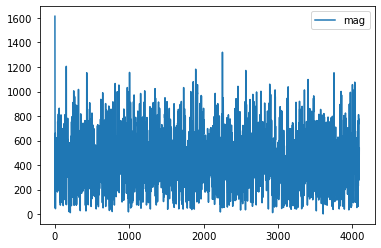

In [430]:
# 64 bit imprecision
real = res_data[1::2]
imag = res_data[0::2]
real_decimal = [get_decimal_from_twos(x, num_width) for x in real]
imag_decimal = [get_decimal_from_twos(x, num_width) for x in imag]

# plt.plot(list(range(N)), real_decimal, label='real')
# plt.plot(list(range(N)), imag_decimal, label='imag')
plt.plot(list(range(N)), [np.sqrt(r**2+i**2) for (r, i) in zip(real_decimal, imag_decimal)], label='mag')
plt.legend()

In [434]:
def get_conv_data(): #outputs 1 code block
    mmio_interface.write(0x08, 0)
    res_data = allocate(2*N, dtype=np.uint32)
    time.sleep(0.0005)
    mmio_interface.write(0x08, 1)
    
    # for debug: ask for IQ and PRN data into
    dma_iq.recvchannel.transfer(iq_data)
    dma_iq.recvchannel.wait()
    dma_prn.recvchannel.transfer(prn_data)
    dma_prn.recvchannel.wait()
    
    # then pass it on to convolution
    dma_iq.sendchannel.transfer(iq_data)
    dma_prn.sendchannel.transfer(prn_data)
    dma_iq.sendchannel.wait()
    dma_prn.sendchannel.wait()
    
    # and read output
    dma_output.recvchannel.transfer(res_data)
    dma_output.recvchannel.wait()
    return res_data

In [435]:
def doppler_sweep(prn_id, start = -8000, end = 8000, step = 100, scaling = 16): #sweeps frequency range
    doppler_range = list(range(start, end, step))
    mmio_interface.write(0x00, scaling)
    mmio_interface.write(0x04, prn_id-1)

    amplitudes = []
    for doppler in doppler_range:
        
#         if doppler % 1000 == 0: print(f'on doppler {doppler}')
            
        # set adc frequency now
        adc_block.MixerSettings['Freq']= center_frequency + doppler / 1e6 # set the frequency of the Numerically controlled oscillator.
        adc_block.UpdateEvent(xrfdc.EVENT_MIXER) #every time setting is changed, must call this.
        
        res_data = get_conv_data()

        # now do calculation
        real = res_data[1::2]
        imag = res_data[0::2]
        real_decimal = [get_decimal_from_twos(x, num_width) for x in real]
        imag_decimal = [get_decimal_from_twos(x, num_width) for x in imag]
        convolve = np.array([x+y*1j for (x,y) in zip(real_decimal, imag_decimal)])
        peak_position = np.argmax(abs(convolve))
        amplitudes.append(abs(convolve)[peak_position]**2)

    plt.plot(doppler_range, amplitudes)
    best_doppler = np.argmax(amplitudes)
    return amplitudes

In [436]:
def prn_sweep(start = -5000, end = 5000, step = 100, scaling = 16): #sweeps all 37 prns
    full_data = []
    for i in range(1,38):
        amplitudes = doppler_sweep(i,start=start, end=end, step=step, scaling=scaling)
        full_data.append(amplitudes)
        print(f"Frequency sweep of prn ID {i}, max {max(amplitudes)}")        
    return full_data

on doppler -5000
on doppler -4000
on doppler -3000
on doppler -2000
on doppler -1000
on doppler 0
on doppler 1000
on doppler 2000
on doppler 3000
on doppler 4000
Frequency sweep of prn ID 1, max 69384429.00000001
on doppler -5000
on doppler -4000
on doppler -3000
on doppler -2000
on doppler -1000
on doppler 0
on doppler 1000
on doppler 2000
on doppler 3000
on doppler 4000
Frequency sweep of prn ID 2, max 39819040.00000001
on doppler -5000
on doppler -4000
on doppler -3000
on doppler -2000
on doppler -1000
on doppler 0
on doppler 1000
on doppler 2000
on doppler 3000
on doppler 4000
Frequency sweep of prn ID 3, max 41214274.0
on doppler -5000
on doppler -4000
on doppler -3000
on doppler -2000
on doppler -1000
on doppler 0
on doppler 1000
on doppler 2000
on doppler 3000
on doppler 4000
Frequency sweep of prn ID 4, max 42958401.99999999
on doppler -5000
on doppler -4000
on doppler -3000
on doppler -2000
on doppler -1000
on doppler 0
on doppler 1000
on doppler 2000
on doppler 3000
on dopple

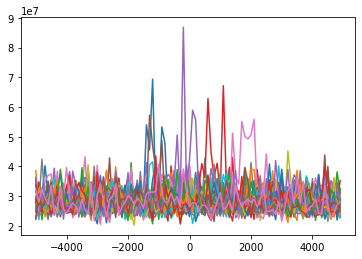

In [437]:
full_data = prn_sweep()